In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
df = pd.read_csv('autos.csv', encoding='ISO-8859-1')

In [3]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df[['powerPS', 'kilometer', 'yearOfRegistration', 'brand', 'vehicleType', 'price']]

,powerPS,kilometer,yearOfRegistration,brand,vehicleType,price
0,0,150000,1993,volkswagen,NaN,480
1,190,125000,2011,audi,coupe,18300
2,163,125000,2004,jeep,suv,9800
3,75,150000,2001,volkswagen,kleinwagen,1500
4,69,90000,2008,skoda,kleinwagen,3600
...,...,...,...,...,...,...
371523,0,20000,2005,sonstige_autos,NaN,2200
371524,101,125000,2000,smart,cabrio,1199
371525,102,150000,1996,volkswagen,bus,9200
371526,100,150000,2002,volkswagen,kombi,3400


In [5]:
class CustomModel(nn.Module):
    def __init__(self, emb_size, n_cont, p=0.5, h1=150, h2=100, h3=30, out_features=1):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_size])
        self.dropout1 = nn.Dropout(p)
        self.dropout2 = nn.Dropout(p)
        self.dropout3 = nn.Dropout(p)

        n_emb = sum((nf for ni, nf in emb_size))

        self.bn_cont = nn.BatchNorm1d(n_cont)

        self.fc1 = nn.Linear(n_cont + n_emb, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.fc3 = nn.Linear(h2, h3)
        self.bn3 = nn.BatchNorm1d(h3)
        self.out = nn.Linear(h3, out_features)

    def forward(self, x_cat, x_cont):

        embeddings = []
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)

        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.out(x)
        return x

In [26]:
class UsedCarDataset(Dataset):
    def __init__(self):
        df = pd.read_csv('autos.csv', encoding='ISO-8859-1')
        df = df[['powerPS', 'kilometer', 'yearOfRegistration', 'brand', 'vehicleType', 'price']]
        df = df.dropna()
        df = df.reset_index(drop=True)
        df = df[df['price'] > 100]
        df = df[df['price'] < 30000]
        df = df[df['powerPS'] > 30]

        df['price'] = df['price'] / 100
        df['kilometer'] = df['kilometer'] / 1000
        df['yearOfRegistration'] = df['yearOfRegistration'] / 1000
        df['powerPS'] = df['powerPS'] / 100

        print(df.head())

        categ_cols = ['brand', 'vehicleType']
        contin_cols = ['powerPS', 'kilometer', 'yearOfRegistration']
        y_col = ['price']

        for cat in categ_cols:
            df[cat] = df[cat].astype('category')

        br = df['brand'].cat.codes.values
        vt = df['vehicleType'].cat.codes.values
        print(df['brand'].cat.codes.values)
        print(df['brand'].cat.categories)
        print(df['vehicleType'].cat.categories)
        categs = np.stack([br, vt], 1)
        self.categs = torch.tensor(categs, dtype=torch.int64)

        contins = np.stack([df[col].values for col in contin_cols], 1)
        self.contins = torch.tensor(contins,dtype=torch.float)

        y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

        cat_size = [df[col].cat.categories.size for col in categ_cols]
        self.emb_size = [(size, min(50, (size+1) // 2)) for size in cat_size]

        data_size = len(y)
        test_size = int(data_size * 0.2)

        self.cat_train = self.categs[:data_size - test_size]
        self.cat_test = self.categs[data_size - test_size:]
        self.con_train = self.contins[:data_size - test_size]
        self.con_test = self.contins[data_size - test_size:]
        self.y_train = y[:data_size - test_size]
        self.y_test = y[data_size - test_size:]

        self.num = len(self.y_train)

    def __getitem__(self, index):
        return self.cat_train[index], self.con_train[index], self.y_train[index]

    def __len__(self):
        return self.num


In [27]:
dataset = UsedCarDataset()
total_samples = len(dataset)
print(total_samples)

   powerPS  kilometer  yearOfRegistration       brand vehicleType  price
0     1.90      125.0               2.011        audi       coupe  183.0
1     1.63      125.0               2.004        jeep         suv   98.0
2     0.75      150.0               2.001  volkswagen  kleinwagen   15.0
3     0.69       90.0               2.008       skoda  kleinwagen   36.0
4     1.02      150.0               1.995         bmw   limousine    6.5
[ 1 14 38 ... 38 38  2]
Index(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen',
       'volvo'],
      dtype='object')
Index(['andere', 'bus', 'cabrio', 'coupe', 'kleinwage

In [15]:
epochs = 15
batchsize = 13000
n_iterations = math.ceil(total_samples/batchsize)

In [16]:
loss_list = []
trainloader =DataLoader(dataset=dataset, batch_size=batchsize, shuffle=True)

In [17]:
dataset.emb_size

[(40, 20), (8, 4)]

In [18]:
torch.manual_seed(3)
model = CustomModel(dataset.emb_size, 3, p=0.3, h1=50, h2=50, h3=30, out_features=1)

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
for epoch in range(epochs):
    for i, data in enumerate(trainloader):
        cat_train, con_train, labels = data

        y_pred = model(cat_train,con_train)
        loss = torch.sqrt(criterion(y_pred, labels))
        loss_list.append(loss.detach())

        print(f'Epoch {epoch+1}/{epochs} Iteration {i+1}/{n_iterations} Category {cat_train.shape} \
            Continuous {con_train.shape} Loss {loss.item():.3f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 1/15 Iteration 1/19 Category torch.Size([13000, 2])             Continuous torch.Size([13000, 3]) Loss 81.519
Epoch 1/15 Iteration 2/19 Category torch.Size([13000, 2])             Continuous torch.Size([13000, 3]) Loss 81.669
Epoch 1/15 Iteration 3/19 Category torch.Size([13000, 2])             Continuous torch.Size([13000, 3]) Loss 81.770
Epoch 1/15 Iteration 4/19 Category torch.Size([13000, 2])             Continuous torch.Size([13000, 3]) Loss 80.555
Epoch 1/15 Iteration 5/19 Category torch.Size([13000, 2])             Continuous torch.Size([13000, 3]) Loss 80.481
Epoch 1/15 Iteration 6/19 Category torch.Size([13000, 2])             Continuous torch.Size([13000, 3]) Loss 80.592
Epoch 1/15 Iteration 7/19 Category torch.Size([13000, 2])             Continuous torch.Size([13000, 3]) Loss 80.467
Epoch 1/15 Iteration 8/19 Category torch.Size([13000, 2])             Continuous torch.Size([13000, 3]) Loss 79.285
Epoch 1/15 Iteration 9/19 Category torch.Size([13000, 2])             Co

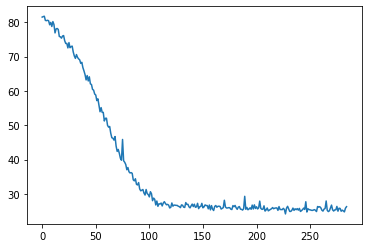

In [21]:
plt.plot(loss_list)

In [22]:
torch.save(model.state_dict(), 'GermanyCarModel.pt')

In [23]:
with torch.no_grad():
    y_val = model(dataset.cat_test, dataset.con_test)
    loss = torch.sqrt(criterion(y_val, dataset.y_test))
    print(f'{loss.item():.3f}')

25.378


In [25]:
print(f'Predicted_y    True_y    Error')
for i in range(30):
    error = np.abs(y_val[i].item() - dataset.y_test[i].item())
    print(f'{i+1}.  {y_val[i].item():.3f}    {dataset.y_test[i].item():.3f}    {error:.3f}')

Predicted_y    True_y    Error
1.  89.554    115.000    25.446
2.  9.431    16.990    7.559
3.  62.611    89.990    27.379
4.  8.218    6.500    1.718
5.  18.059    24.990    6.931
6.  23.990    19.000    4.990
7.  66.750    35.000    31.750
8.  161.940    165.000    3.060
9.  14.348    1.500    12.848
10.  99.006    80.000    19.006
11.  47.099    38.000    9.099
12.  186.622    185.000    1.622
13.  43.769    29.000    14.769
14.  39.453    29.000    10.453
15.  118.429    119.990    1.561
16.  62.986    58.500    4.486
17.  98.349    84.990    13.359
18.  15.842    8.000    7.842
19.  50.118    32.900    17.218
20.  12.140    9.800    2.340
21.  90.059    180.000    89.941
22.  3.548    3.990    0.442
23.  175.797    162.000    13.797
24.  68.736    79.000    10.264
25.  113.802    129.900    16.098
26.  114.436    60.000    54.436
27.  91.801    135.000    43.199
28.  11.377    14.490    3.113
29.  21.193    7.500    13.693
30.  19.304    16.600    2.704


In [28]:
model.eval()

CustomModel(
  (embeds): ModuleList(
    (0): Embedding(40, 20)
    (1): Embedding(8, 4)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=27, out_features=50, bias=True)
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=50, out_features=30, bias=True)
  (bn3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=30, out_features=1, bias=True)
)

In [29]:
xcats = [[1, 3]]
xcats = torch.tensor(xcats, dtype=torch.int64)
xconts = [[1.9, 125.0, 2.011]]
xconts = torch.tensor(xconts, dtype=torch.float)

with torch.no_grad():
    predict = model(xcats, xconts)
    print(predict)

tensor([[187.6778]])
